<a href="https://colab.research.google.com/github/mdsiam135/thesis_2025/blob/main/DenseNet(3_labels).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
# =============================================================================
# STEP 0: IMPORT LIBRARIES AND SETUP
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("✅ All libraries imported successfully!")
print("✅ Random seeds set for reproducibility")


✅ All libraries imported successfully!
✅ Random seeds set for reproducibility


In [41]:

# =============================================================================
# STEP 1: DEFINE DENSENET CLASS AND HELPER FUNCTIONS
# =============================================================================

class DenseNetTabular:
    def __init__(self, input_dim, num_classes=3):
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.model = None
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        self.history = None

    def create_dense_block(self, x, growth_rate, num_layers, name):
        """Create a dense block with specified growth rate and number of layers"""
        for i in range(num_layers):
            # Batch normalization and ReLU activation
            bn = layers.BatchNormalization(name=f'{name}_bn_{i}')(x)
            relu = layers.ReLU(name=f'{name}_relu_{i}')(bn)

            # Dense layer with growth rate
            conv = layers.Dense(growth_rate, name=f'{name}_dense_{i}')(relu)

            # Concatenate with input (skip connection)
            x = layers.Concatenate(name=f'{name}_concat_{i}')([x, conv])

        return x

    def create_transition_layer(self, x, compression_factor, name):
        """Create transition layer for dimensionality reduction"""
        # Get number of features
        num_features = x.shape[-1]

        # Batch normalization and ReLU
        bn = layers.BatchNormalization(name=f'{name}_bn')(x)
        relu = layers.ReLU(name=f'{name}_relu')(bn)

        # Compress features
        compressed_features = int(num_features * compression_factor)
        dense = layers.Dense(compressed_features, name=f'{name}_dense')(relu)

        # Dropout for regularization
        dropout = layers.Dropout(0.2, name=f'{name}_dropout')(dense)

        return dropout

    def build_model(self):
        """Build DenseNet architecture for tabular data"""
        # Input layer
        inputs = layers.Input(shape=(self.input_dim,), name='input')

        # Initial dense layer
        x = layers.Dense(64, activation='relu', name='initial_dense')(inputs)
        x = layers.BatchNormalization(name='initial_bn')(x)
        x = layers.Dropout(0.1, name='initial_dropout')(x)

        # Dense Block 1
        x = self.create_dense_block(x, growth_rate=32, num_layers=3, name='dense_block_1')
        x = self.create_transition_layer(x, compression_factor=0.5, name='transition_1')

        # Dense Block 2
        x = self.create_dense_block(x, growth_rate=32, num_layers=3, name='dense_block_2')
        x = self.create_transition_layer(x, compression_factor=0.5, name='transition_2')

        # Dense Block 3
        x = self.create_dense_block(x, growth_rate=32, num_layers=3, name='dense_block_3')

        # Global Average Pooling equivalent for tabular data
        x = layers.BatchNormalization(name='final_bn')(x)
        x = layers.ReLU(name='final_relu')(x)

        # Classification head
        x = layers.Dense(128, activation='relu', name='classifier_dense_1')(x)
        x = layers.Dropout(0.3, name='classifier_dropout_1')(x)
        x = layers.Dense(64, activation='relu', name='classifier_dense_2')(x)
        x = layers.Dropout(0.2, name='classifier_dropout_2')(x)

        # Output layer for 3 classes
        outputs = layers.Dense(self.num_classes, activation='softmax', name='output')(x)

        # Create model
        self.model = keras.Model(inputs=inputs, outputs=outputs, name='DenseNet_Tabular')

        return self.model

    def compile_model(self, learning_rate=0.001):
        """Compile the model with optimizer and loss function"""
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        self.model.compile(
            optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

    def preprocess_data(self, df, target_column, is_training=True):
        """Preprocess the data for training with 3-class classification"""
        # Separate features and target
        X = df.drop(columns=[target_column])
        y = df[target_column]

        if is_training:
            # Create quantile-based labels for training data (3 classes)
            quantiles = y.quantile([0.33, 0.67])  # 33rd and 67th percentiles
            labels = []
            for value in y:
                if value <= quantiles[0.33]:
                    labels.append('low')
                elif value <= quantiles[0.67]:
                    labels.append('medium')
                else:
                    labels.append('high')

            # Store quantiles for later use
            self.quantiles = quantiles

            # Print quantile information
            print(f"Quantile boundaries:")
            print(f"Low: <= {quantiles[0.33]:.2f}")
            print(f"Medium: {quantiles[0.33]:.2f} - {quantiles[0.67]:.2f}")
            print(f"High: > {quantiles[0.67]:.2f}")

            # Fit label encoder and scaler
            y_encoded = self.label_encoder.fit_transform(labels)
            X_scaled = self.scaler.fit_transform(X)
        else:
            # Use existing quantiles for validation/test data
            labels = []
            for value in y:
                if value <= self.quantiles[0.33]:
                    labels.append('low')
                elif value <= self.quantiles[0.67]:
                    labels.append('medium')
                else:
                    labels.append('high')

            # Transform using fitted encoders
            y_encoded = self.label_encoder.transform(labels)
            X_scaled = self.scaler.transform(X)

        # Convert to categorical
        y_categorical = keras.utils.to_categorical(y_encoded, num_classes=self.num_classes)

        # Print class distribution
        unique, counts = np.unique(labels, return_counts=True)
        print(f"Class distribution: {dict(zip(unique, counts))}")

        return X_scaled, y_categorical, y_encoded, labels

def calculate_metrics(y_true, y_pred):
    """Calculate all required metrics"""
    accuracy = accuracy_score(y_true, y_pred)
    precision_weighted = precision_score(y_true, y_pred, average='weighted')
    recall_weighted = recall_score(y_true, y_pred, average='weighted')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    macro_f1 = f1_score(y_true, y_pred, average='macro')

    # Individual class metrics
    precision_per_class = precision_score(y_true, y_pred, average=None)
    recall_per_class = recall_score(y_true, y_pred, average=None)
    f1_per_class = f1_score(y_true, y_pred, average=None)

    return {
        'accuracy': accuracy,
        'precision_weighted': precision_weighted,
        'recall_weighted': recall_weighted,
        'f1_weighted': f1_weighted,
        'macro_f1': macro_f1,
        'precision_per_class': precision_per_class,
        'recall_per_class': recall_per_class,
        'f1_per_class': f1_per_class
    }

def plot_confusion_matrix(y_true, y_pred, labels, title, save_path=None):
    """Plot confusion matrix with better formatting"""
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(5, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels,
                cbar_kws={'label': 'Count'})
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    return cm

def plot_training_history(history, save_path=None):
    """Plot training and validation accuracy/loss"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    ax1.set_title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss', linewidth=2)
    ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    ax2.set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def print_detailed_metrics(metrics, class_labels, dataset_name):
    """Print detailed metrics in a formatted way"""
    print(f"\n{dataset_name.upper()} METRICS:")
    print("-" * 50)
    print(f"Overall Accuracy: {metrics['accuracy']:.4f}")
    print(f"Weighted Precision: {metrics['precision_weighted']:.4f}")
    print(f"Weighted Recall: {metrics['recall_weighted']:.4f}")
    print(f"Weighted F1-Score: {metrics['f1_weighted']:.4f}")
    print(f"Macro F1-Score: {metrics['macro_f1']:.4f}")

    print(f"\nPer-Class Metrics:")
    print("-" * 30)
    for i, label in enumerate(class_labels):
        print(f"{label.capitalize()}:")
        print(f"  Precision: {metrics['precision_per_class'][i]:.4f}")
        print(f"  Recall: {metrics['recall_per_class'][i]:.4f}")
        print(f"  F1-Score: {metrics['f1_per_class'][i]:.4f}")

print("✅ DenseNet class and helper functions defined!")


✅ DenseNet class and helper functions defined!


In [42]:

# =============================================================================
# STEP 2: LOAD AND PREPROCESS DATASETS
# =============================================================================

print("="*60)
print("STEP 2: LOADING DATASETS")
print("="*60)

try:
    # Load datasets - UPDATE THESE PATHS TO YOUR ACTUAL FILE PATHS
    train_df = pd.read_csv('/content/drive/MyDrive/UpdatedDataset/train.csv')
    val_df = pd.read_csv('/content/drive/MyDrive/UpdatedDataset/validation.csv')
    test_df = pd.read_csv('/content/drive/MyDrive/UpdatedDataset/test.csv')

    print(f"✓ Train dataset loaded: {train_df.shape}")
    print(f"✓ Validation dataset loaded: {val_df.shape}")
    print(f"✓ Test dataset loaded: {test_df.shape}")

    # Display basic info about the target variable
    print(f"\nProduction (M.Ton) statistics in training data:")
    print(f"Min: {train_df['Production (M.Ton)'].min():.2f}")
    print(f"Max: {train_df['Production (M.Ton)'].max():.2f}")
    print(f"Mean: {train_df['Production (M.Ton)'].mean():.2f}")
    print(f"Std: {train_df['Production (M.Ton)'].std():.2f}")

except FileNotFoundError as e:
    print(f"Error loading files: {e}")
    print("Please update the file paths in the code above and run again")

# Check for missing values
print(f"\nMissing values:")
print(f"Train: {train_df.isnull().sum().sum()}")
print(f"Validation: {val_df.isnull().sum().sum()}")
print(f"Test: {test_df.isnull().sum().sum()}")

# Handle missing values if any
if train_df.isnull().sum().sum() > 0:
    print("Filling missing values with mean...")
    numeric_columns = train_df.select_dtypes(include=[np.number]).columns
    train_df[numeric_columns] = train_df[numeric_columns].fillna(train_df[numeric_columns].mean())
    val_df[numeric_columns] = val_df[numeric_columns].fillna(val_df[numeric_columns].mean())
    test_df[numeric_columns] = test_df[numeric_columns].fillna(test_df[numeric_columns].mean())


STEP 2: LOADING DATASETS
✓ Train dataset loaded: (3942, 84)
✓ Validation dataset loaded: (845, 84)
✓ Test dataset loaded: (845, 84)

Production (M.Ton) statistics in training data:
Min: 0.00
Max: 544979.50
Mean: 7860.82
Std: 32823.84

Missing values:
Train: 0
Validation: 0
Test: 0


In [43]:

# =============================================================================
# STEP 3: INITIALIZE DENSENET MODEL
# =============================================================================

print("\n" + "="*60)
print("STEP 3: INITIALIZING DENSENET MODEL")
print("="*60)

# Get input dimension (excluding target column)
input_dim = train_df.shape[1] - 1  # Subtract 1 for target column
print(f"Input dimension: {input_dim} features")

# Initialize DenseNet for 3-class classification
densenet = DenseNetTabular(input_dim=input_dim, num_classes=3)
print("✅ DenseNet model initialized!")



STEP 3: INITIALIZING DENSENET MODEL
Input dimension: 83 features
✅ DenseNet model initialized!


In [44]:

# =============================================================================
# STEP 4: PREPROCESS ALL DATASETS
# =============================================================================

print("\n" + "="*60)
print("STEP 4: PREPROCESSING DATASETS")
print("="*60)

# Preprocess training data
print("Processing training data...")
X_train, y_train_cat, y_train_encoded, train_labels = densenet.preprocess_data(
    train_df, 'Production (M.Ton)', is_training=True
)

print("\nProcessing validation data...")
# Preprocess validation data
X_val, y_val_cat, y_val_encoded, val_labels = densenet.preprocess_data(
    val_df, 'Production (M.Ton)', is_training=False
)

print("\nProcessing test data...")
# Preprocess test data
X_test, y_test_cat, y_test_encoded, test_labels = densenet.preprocess_data(
    test_df, 'Production (M.Ton)', is_training=False
)

print(f"\nData shapes after preprocessing:")
print(f"Training: {X_train.shape}")
print(f"Validation: {X_val.shape}")
print(f"Test: {X_test.shape}")



STEP 4: PREPROCESSING DATASETS
Processing training data...
Quantile boundaries:
Low: <= 1071.56
Medium: 1071.56 - 4035.91
High: > 4035.91
Class distribution: {np.str_('high'): np.int64(1301), np.str_('low'): np.int64(1301), np.str_('medium'): np.int64(1340)}

Processing validation data...
Class distribution: {np.str_('high'): np.int64(270), np.str_('low'): np.int64(278), np.str_('medium'): np.int64(297)}

Processing test data...
Class distribution: {np.str_('high'): np.int64(291), np.str_('low'): np.int64(274), np.str_('medium'): np.int64(280)}

Data shapes after preprocessing:
Training: (3942, 83)
Validation: (845, 83)
Test: (845, 83)


In [45]:

# =============================================================================
# STEP 5: BUILD AND COMPILE MODEL
# =============================================================================

print("\n" + "="*60)
print("STEP 5: BUILDING AND COMPILING MODEL")
print("="*60)

model = densenet.build_model()
densenet.compile_model(learning_rate=0.001)

print("✓ Model built successfully!")
print(f"✓ Total parameters: {model.count_params():,}")

# Display model architecture
print("\nModel Architecture Summary:")
model.summary()



STEP 5: BUILDING AND COMPILING MODEL
✓ Model built successfully!
✓ Total parameters: 104,011

Model Architecture Summary:


Model: "DenseNet_Tabular"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 83)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ initial_dense       │ (None, 64)        │      5,376 │ input[0][0]       │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ initial_bn          │ (None, 64)        │        256 │ initial_dense[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ initial_dropout     │ (None, 64)        │          0 │ initial_bn[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_block_1_bn_0  │ (None, 64)        │        256 │ initial_dropout[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_block_1_relu… │ (None, 64)        │          0 │ dense_block_1_bn… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_block_1_dens… │ (None, 32)        │      2,080 │ dense_block_1_re… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_block_1_conc… │ (None, 96)        │          0 │ initial_dropout[… │
│ (Concatenate)       │                   │            │ dense_block_1_de… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_block_1_bn_1  │ (None, 96)        │        384 │ dense_block_1_co… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_block_1_relu… │ (None, 96)        │          0 │ dense_block_1_bn… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_block_1_dens… │ (None, 32)        │      3,104 │ dense_block_1_re… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_block_1_conc… │ (None, 128)       │          0 │ dense_block_1_co… │
│ (Concatenate)       │                   │            │ dense_block_1_de… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_block_1_bn_2  │ (None, 128)       │        512 │ dense_block_1_co… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_block_1_relu… │ (None, 128)       │          0 │ dense_block_1_bn… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_block_1_dens… │ (None, 32)        │      4,128 │ dense_block_1_re… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_block_1_conc… │ (None, 160)       │          0 │ dense_block_1_co… │
│ (Concatenate)       │                   │            │ dense_block_1_de… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transition_1_bn     │ (None, 160)       │        640 │ dense_block_1_co… │
│ (BatchNormalizatio… │                   │            │                 

 Total params: 104,011 (406.29 KB)

 Trainable params: 100,875 (394.04 KB)

 Non-trainable params: 3,136 (12.25 KB)

In [46]:

# =============================================================================
# STEP 6: TRAIN THE MODEL
# =============================================================================

print("\n" + "="*60)
print("STEP 6: TRAINING THE MODEL")
print("="*60)

# Define callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1
)

# Training parameters
epochs = 100
batch_size = 32

print(f"Training parameters:")
print(f"- Epochs: {epochs}")
print(f"- Batch size: {batch_size}")
print(f"- Early stopping patience: 15")
print(f"- Learning rate reduction patience: 7")

# Train the model
print("\nStarting training...")
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

densenet.history = history
print("✅ Training completed!")



STEP 6: TRAINING THE MODEL
Training parameters:
- Epochs: 100
- Batch size: 32
- Early stopping patience: 15
- Learning rate reduction patience: 7

Starting training...
Epoch 1/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.3770 - loss: 1.1371 - val_accuracy: 0.5657 - val_loss: 0.9365 - learning_rate: 0.0010
Epoch 2/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5353 - loss: 0.9383 - val_accuracy: 0.6793 - val_loss: 0.6833 - learning_rate: 0.0010
Epoch 3/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6831 - loss: 0.7273 - val_accuracy: 0.7160 - val_loss: 0.5985 - learning_rate: 0.0010
Epoch 4/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7421 - loss: 0.5968 - val_accuracy: 0.7574 - val_loss: 0.5282 - learning_rate: 0.0010
Epoch 5/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7652 - loss: 0.5591 - val_accuracy: 0.7834 - val_loss: 0.4923 - learning_rate: 0.0010
Epoch 6/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy

In [47]:

# =============================================================================
# STEP 7: EVALUATE ON VALIDATION SET
# =============================================================================

print("\n" + "="*60)
print("STEP 7: VALIDATION SET EVALUATION")
print("="*60)

# Predictions on validation set
print("Making predictions on validation set...")
val_pred_probs = model.predict(X_val, verbose=0)
val_pred_encoded = np.argmax(val_pred_probs, axis=1)

# Calculate metrics for validation
val_metrics = calculate_metrics(y_val_encoded, val_pred_encoded)

# Class labels
class_labels = ['high', 'low', 'medium']  # Alphabetical order after label encoding

# Print detailed metrics
print_detailed_metrics(val_metrics, class_labels, "validation")



STEP 7: VALIDATION SET EVALUATION
Making predictions on validation set...

VALIDATION METRICS:
--------------------------------------------------
Overall Accuracy: 0.9006
Weighted Precision: 0.9003
Weighted Recall: 0.9006
Weighted F1-Score: 0.9004
Macro F1-Score: 0.9014

Per-Class Metrics:
------------------------------
High:
  Precision: 0.9007
  Recall: 0.9074
  F1-Score: 0.9041
Low:
  Precision: 0.9359
  Recall: 0.9460
  F1-Score: 0.9410
Medium:
  Precision: 0.8664
  Recall: 0.8519
  F1-Score: 0.8591


In [48]:

# =============================================================================
# STEP 8: EVALUATE ON TEST SET
# =============================================================================

print("\n" + "="*60)
print("STEP 8: TEST SET EVALUATION")
print("="*60)

# Predictions on test set
print("Making predictions on test set...")
test_pred_probs = model.predict(X_test, verbose=0)
test_pred_encoded = np.argmax(test_pred_probs, axis=1)

# Calculate metrics for test
test_metrics = calculate_metrics(y_test_encoded, test_pred_encoded)

# Print detailed metrics
print_detailed_metrics(test_metrics, class_labels, "test")



STEP 8: TEST SET EVALUATION
Making predictions on test set...

TEST METRICS:
--------------------------------------------------
Overall Accuracy: 0.9243
Weighted Precision: 0.9240
Weighted Recall: 0.9243
Weighted F1-Score: 0.9239
Macro F1-Score: 0.9241

Per-Class Metrics:
------------------------------
High:
  Precision: 0.9133
  Recall: 0.9416
  F1-Score: 0.9272
Low:
  Precision: 0.9496
  Recall: 0.9635
  F1-Score: 0.9565
Medium:
  Precision: 0.9101
  Recall: 0.8679
  F1-Score: 0.8885



STEP 9: CREATING VISUALIZATIONS
📊 Plotting training history...


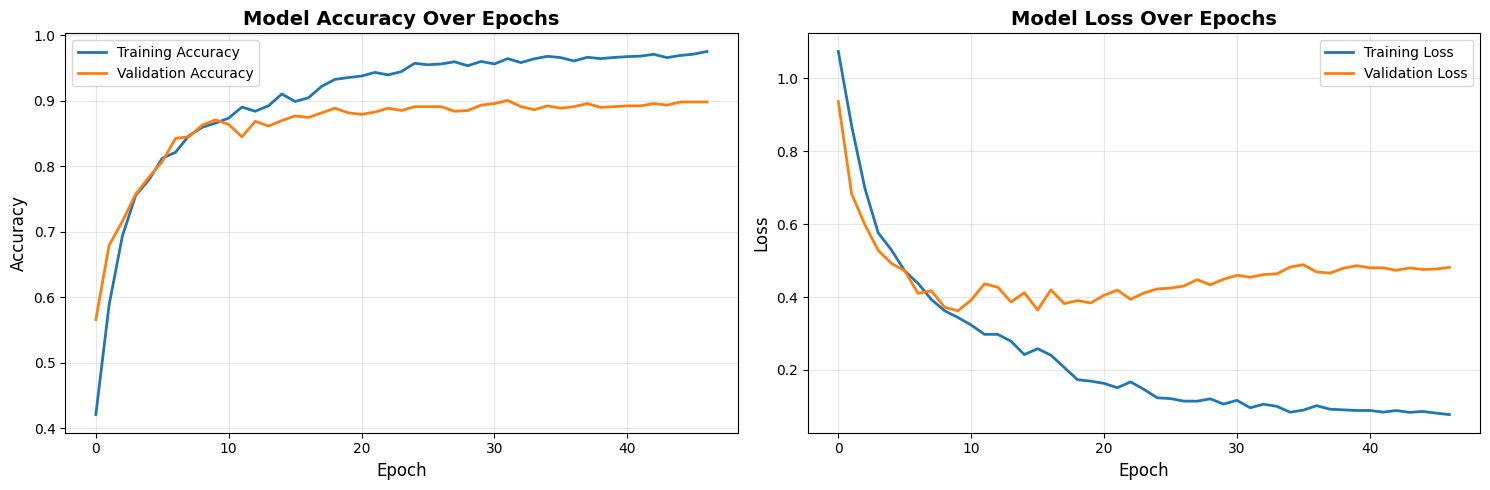

In [49]:

# =============================================================================
# STEP 9: CREATE VISUALIZATIONS
# =============================================================================

print("\n" + "="*60)
print("STEP 9: CREATING VISUALIZATIONS")
print("="*60)

# Plot training history
print("📊 Plotting training history...")
plot_training_history(history)


📊 Plotting confusion matrix for validation...


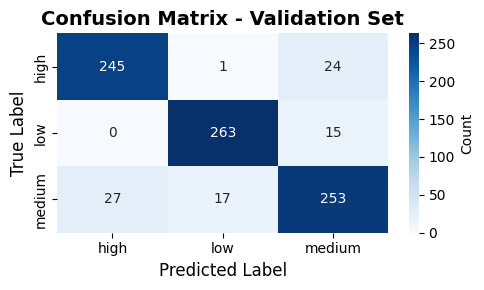

📊 Plotting confusion matrix for test...


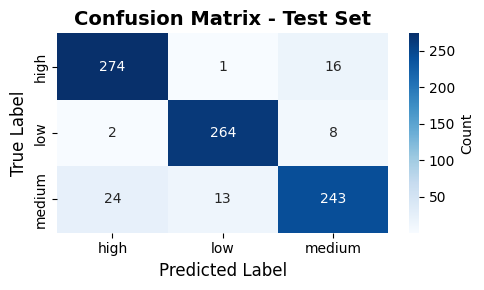

In [50]:

# =============================================================================
# STEP 10: PLOT CONFUSION MATRICES
# =============================================================================

# Plot confusion matrix for validation
print("📊 Plotting confusion matrix for validation...")
val_cm = plot_confusion_matrix(
    y_val_encoded, val_pred_encoded,
    class_labels,
    'Confusion Matrix - Validation Set'
)

# Plot confusion matrix for test
print("📊 Plotting confusion matrix for test...")
test_cm = plot_confusion_matrix(
    y_test_encoded, test_pred_encoded,
    class_labels,
    'Confusion Matrix - Test Set'
)


In [51]:

# =============================================================================
# STEP 11: DETAILED CLASSIFICATION REPORTS
# =============================================================================

print("\n" + "="*60)
print("STEP 11: DETAILED CLASSIFICATION REPORTS")
print("="*60)

print("VALIDATION CLASSIFICATION REPORT:")
print("-" * 40)
print(classification_report(y_val_encoded, val_pred_encoded,
                          target_names=class_labels, digits=4))

print("\nTEST CLASSIFICATION REPORT:")
print("-" * 40)
print(classification_report(y_test_encoded, test_pred_encoded,
                          target_names=class_labels, digits=4))



STEP 11: DETAILED CLASSIFICATION REPORTS
VALIDATION CLASSIFICATION REPORT:
----------------------------------------
              precision    recall  f1-score   support

        high     0.9007    0.9074    0.9041       270
         low     0.9359    0.9460    0.9410       278
      medium     0.8664    0.8519    0.8591       297

    accuracy                         0.9006       845
   macro avg     0.9010    0.9018    0.9014       845
weighted avg     0.9003    0.9006    0.9004       845


TEST CLASSIFICATION REPORT:
----------------------------------------
              precision    recall  f1-score   support

        high     0.9133    0.9416    0.9272       291
         low     0.9496    0.9635    0.9565       274
      medium     0.9101    0.8679    0.8885       280

    accuracy                         0.9243       845
   macro avg     0.9244    0.9243    0.9241       845
weighted avg     0.9240    0.9243    0.9239       845



In [52]:

# =============================================================================
# STEP 12: FINAL SUMMARY
# =============================================================================

print("\n" + "="*60)
print("STEP 12: FINAL SUMMARY")
print("="*60)

print("🎯 FINAL RESULTS SUMMARY:")
print("-" * 30)
print(f"Training Epochs Completed: {len(history.history['accuracy'])}")
print(f"Best Training Accuracy: {max(history.history['accuracy']):.4f}")
print(f"Best Validation Accuracy: {max(history.history['val_accuracy']):.4f}")
print()
print("VALIDATION PERFORMANCE:")
print(f"  ✓ Accuracy: {val_metrics['accuracy']:.4f}")
print(f"  ✓ Macro F1-Score: {val_metrics['macro_f1']:.4f}")
print(f"  ✓ Weighted F1-Score: {val_metrics['f1_weighted']:.4f}")
print()
print("TEST PERFORMANCE:")
print(f"  ✓ Accuracy: {test_metrics['accuracy']:.4f}")
print(f"  ✓ Macro F1-Score: {test_metrics['macro_f1']:.4f}")
print(f"  ✓ Weighted F1-Score: {test_metrics['f1_weighted']:.4f}")

# Model performance comparison
print(f"\n📈 PERFORMANCE COMPARISON:")
print(f"Validation vs Test Accuracy: {val_metrics['accuracy']:.4f} vs {test_metrics['accuracy']:.4f}")
print(f"Validation vs Test Macro F1: {val_metrics['macro_f1']:.4f} vs {test_metrics['macro_f1']:.4f}")

if test_metrics['accuracy'] > val_metrics['accuracy']:
    print("✅ Model generalizes well - Test accuracy > Validation accuracy")
else:
    print("⚠️  Potential overfitting - Validation accuracy > Test accuracy")

print("\n" + "="*80)
print("🎉 TRAINING COMPLETED SUCCESSFULLY!")
print("✅ Model is ready for inference on new data.")
print("✅ All visualizations and metrics have been generated.")
print("="*80)


STEP 12: FINAL SUMMARY
🎯 FINAL RESULTS SUMMARY:
------------------------------
Training Epochs Completed: 47
Best Training Accuracy: 0.9754
Best Validation Accuracy: 0.9006

VALIDATION PERFORMANCE:
  ✓ Accuracy: 0.9006
  ✓ Macro F1-Score: 0.9014
  ✓ Weighted F1-Score: 0.9004

TEST PERFORMANCE:
  ✓ Accuracy: 0.9243
  ✓ Macro F1-Score: 0.9241
  ✓ Weighted F1-Score: 0.9239

📈 PERFORMANCE COMPARISON:
Validation vs Test Accuracy: 0.9006 vs 0.9243
Validation vs Test Macro F1: 0.9014 vs 0.9241
✅ Model generalizes well - Test accuracy > Validation accuracy

🎉 TRAINING COMPLETED SUCCESSFULLY!
✅ Model is ready for inference on new data.
✅ All visualizations and metrics have been generated.
